## Open farm and run simple diagnostic


## Load packages

In [1]:
!pip install odc-ui rasterstats

  Using cached odc_ui-0.2.0a3-py3-none-any.whl (15 kB)
  Using cached rasterstats-0.19.0-py3-none-any.whl (16 kB)
  Using cached jupyter_ui_poll-0.2.2-py2.py3-none-any.whl (9.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.6 MB/s eta 0:00:00


In [2]:
import time
start = time.time()

import warnings
warnings.filterwarnings('ignore')

In [3]:
%%time
from grits import get_field, get_lims, get_mms, query_l2a_items, xr_rasterize, calculate_indices

# the basic
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# for PC, stac, xarray
import stackstac
from xrspatial import zonal_stats

# From DEA
import sys
sys.path.append('/home/jovyan/PlanetaryComputerExamples/grasspace/deafrica-sandbox-notebooks/Tools/deafrica_tools/')
from plotting import display_map, rgb, map_shapefile

# packages that have to be installed every runtime
import subprocess
import pkg_resources

required = {'rasterstats','odc-ui'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

CPU times: user 2.71 s, sys: 917 ms, total: 3.63 s
Wall time: 22 s


## Área de análise
Using function get_field for 

1. for fields in a farm - OK
2. for a group in a group of farms - OK
3. for specific fields in a farm - OK
4. ToDo - for an entire farm - the simplest case, as if the polygon was already given straight from a file

In [4]:
path = '/home/jovyan/PlanetaryComputerExamples/vetorial/FAZENDAS/'

# daterange analysis
datetime = "2020-07-10/2023-09-23"


#### Área: Fazenda Uniguiri
**Column parte** contém as regiões

In [5]:

field = gpd.read_file( path + 'fazenda_uniguiri.gpkg')
bbox, lat_range, lon_range = get_lims(field)

print(field.head())
#field.plot()

got bbox, lat_range, lon_range
   parte                                           geometry
0      1  MULTIPOLYGON (((-54.57278 -16.93966, -54.57686...
1      2  MULTIPOLYGON (((-54.57825 -16.95894, -54.57660...
2      3  MULTIPOLYGON (((-54.59494 -16.96052, -54.59700...
3      4  MULTIPOLYGON (((-54.65092 -16.95305, -54.65196...


#### Área: Iacanga - Cana

Grupo de talhoes dentro de todas fazendas de uma usina


### Display bbox study area


In [5]:
style={'opacity': 6, 'stroke': 2,'dashArray': '1', 'fillOpacity': 0.5}
map_shapefile(field,'parte',cmap='Set1', **style )

Label(value='')

Map(center=[-16.95265896271454, -54.60759248224208], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Get images

### get Sentinel 2 L2A Data
colocar as especificidades aqui

In [1]:
%%time
items = query_l2a_items(bbox, datetime, 30)

NameError: name 'query_l2a_items' is not defined

In [7]:
# For Sentinel 2
data = (
    stackstac.stack(
        items,
        assets = ["B11","B12","B08","B06", "B04", "B03","B02", "SCL"],    #["B12","B11","B08","B08","B05","B04","B03","B02"],  
        chunksize=256,
        #resolution=0.0001, #0.0001
        epsg=4326,
        bounds=bbox,
        properties = True,
        fill_value = np.nan,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)

# fix xy names
data = data.rename({'x': 'longitude','y': 'latitude'})

data

<xarray.DataArray 'stackstac-7fbd5f810a1eae6e394c1a01de184b58' (time: 9,
                                                                band: 8,
                                                                latitude: 370,
                                                                longitude: 941)>
dask.array<where, shape=(9, 8, 370, 941), dtype=float64, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2023-07-12...
    id                                       (time) <U54 'S2A_MSIL2A_20230712...
  * band                                     (band) object 'swir16' ... None
  * longitude                                (longitude) float64 -54.65 ... -...
  * latitude                                 (latitude) float64 -16.94 ... -1...
    s2:dark_features_percentage              (time) float64 0.04825 ... 0.05608
    ...                                       ...
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    gsd                                      (band) float64 20.0 20.0 ... 20.0
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-54.65198199605766, -16.969...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-54.65|\n| 0.00,-0.00,-16.94|\n| 0.00, 0.00,...
    resolution_xy:  (9.439942722622163e-05, 9.118049409906348e-05)

### Mask dataset com fazenda

In [8]:
%%time
#create mask versao dataarray
# which also helps to reduce data size
mask = xr_rasterize(field,data,
                    # x_dim='x',
                    # y_dim='y',
                   #export_tiff='masked2.tiff',
                   ) 

# #mask data
data = data.where(mask)

# #convert to float 32 to conserve memory
data = data.astype(np.float32)
data

CPU times: user 29 ms, sys: 264 µs, total: 29.3 ms
Wall time: 27.3 ms


<xarray.DataArray 'stackstac-7fbd5f810a1eae6e394c1a01de184b58' (time: 9,
                                                                band: 8,
                                                                latitude: 370,
                                                                longitude: 941)>
dask.array<astype, shape=(9, 8, 370, 941), dtype=float32, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2023-07-12...
    id                                       (time) <U54 'S2A_MSIL2A_20230712...
  * band                                     (band) object 'swir16' ... None
  * longitude                                (longitude) float64 -54.65 ... -...
  * latitude                                 (latitude) float64 -16.94 ... -1...
    s2:dark_features_percentage              (time) float64 0.04825 ... 0.05608
    ...                                       ...
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    gsd                                      (band) float64 20.0 20.0 ... 20.0
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-54.65198199605766, -16.969...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-54.65|\n| 0.00,-0.00,-16.94|\n| 0.00, 0.00,...
    resolution_xy:  (9.439942722622163e-05, 9.118049409906348e-05)

In [9]:
# calcula indices
ds_ = data.to_dataset(dim='band')

# os indices
indices = ["LAI", "EVI","NDCI","BSI"]
ds = calculate_indices(ds_, 
                       index= indices, 
                       satellite_mission='s2', 
                       drop=True);

Dropping bands ['swir16', 'swir22', 'nir', 'rededge', 'red', 'green', 'blue', None]


In [10]:
%%time
ds.compute()

CPU times: user 4.58 s, sys: 1.35 s, total: 5.93 s
Wall time: 4.3 s


<xarray.Dataset>
Dimensions:                                  (time: 9, longitude: 941,
                                              latitude: 370, band: 8)
Coordinates: (12/43)
  * time                                     (time) datetime64[ns] 2023-07-12...
    id                                       (time) <U54 'S2A_MSIL2A_20230712...
  * longitude                                (longitude) float64 -54.65 ... -...
  * latitude                                 (latitude) float64 -16.94 ... -1...
    s2:dark_features_percentage              (time) float64 0.04825 ... 0.05608
    s2:unclassified_percentage               (time) float64 0.0 0.0 ... 0.6586
    ...                                       ...
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    gsd                                      (band) float64 20.0 20.0 ... 20.0
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Dimensions without coordinates: band
Data variables:
    LAI                                      (time, latitude, longitude) float32 ...
    EVI                                      (time, latitude, longitude) float32 ...
    NDCI                                     (time, latitude, longitude) float32 ...
    BSI                                      (time, latitude, longitude) float32 ...
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-54.65198199605766, -16.969...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-54.65|\n| 0.00,-0.00,-16.94|\n| 0.00, 0.00,...
    resolution_xy:  (9.439942722622163e-05, 9.118049409906348e-05)

## Criar zonas

Rasterizing to match xarray.DataArray dimensions (370, 941)
CPU times: user 147 ms, sys: 16.5 ms, total: 164 ms
Wall time: 157 ms


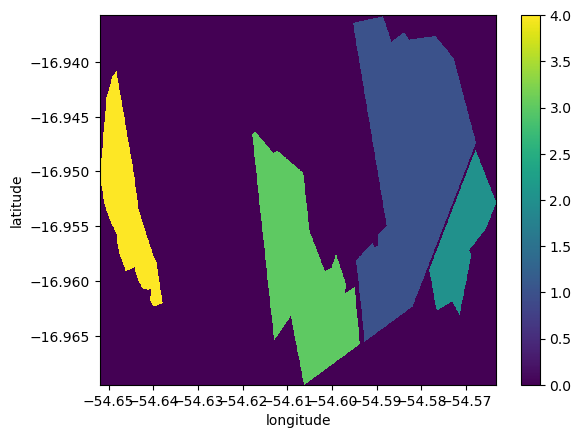

In [11]:
%%time
column = 'parte'
fm = xr_rasterize(field,data,attribute_col=column,verbose=True)
fm = fm.chunk(256)
fm.astype('uint8')
# fm_f64 = fm.astype('float64')
# fm_u8 = fm.astype('uint8')

fm.plot()

### Calculate stats for IVs dataset

#### single image

#### for a series

In [12]:
%%time
nameout = 'x_uniguiri'
verbose = False
for iv in indices:

    # get stats for the first dataframe
    data_ = ds[iv].sel(time=ds[iv].time.values[0]).squeeze()
    print('computing stats for the first date')
    outst = zonal_stats(zones=fm, values=data_).compute()
    outst['date'] = str(ds[iv].time.values[0])
    data_.close()

    # and through the loop
    for t in data.time.values[1:]:
        data_ = ds[iv].sel(time=t).squeeze()
        if verbose: print(f'computing stats for {t}')
        
        outst1 = zonal_stats(zones=fm, values=data_).compute()
        outst1['date'] = str(t)
        outst = pd.concat([outst,outst1])
        data_.close()
        del outst1

    outst.to_csv(f'/home/jovyan/PlanetaryComputerExamples/myout_csv/grasspace/{nameout}_{iv}.csv')
    print(f'{nameout}_{iv}.csv SAVED \n \n')
    del outst

computing stats for the first date
x_uniguiri_LAI.csv SAVED 
 

computing stats for the first date
x_uniguiri_EVI.csv SAVED 
 

computing stats for the first date
x_uniguiri_NDCI.csv SAVED 
 

computing stats for the first date
x_uniguiri_BSI.csv SAVED 
 

CPU times: user 25.2 s, sys: 3.85 s, total: 29 s
Wall time: 18.8 s


### Calculare stats for single image

### Calculate stats for a series

In [13]:
end = time.time()
print(f'{(end - start):.0f} seconds')

28 seconds
